In [128]:
import numpy as np
import pandas as pd
import torch
import torch.utils.data as td
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import matplotlib.colors as colors

froot = './data/k562_epft_chr22_norm'

df = pd.read_csv(froot + ".csv")

In [129]:
print(df.head())

   seqnames     start       end strand  ensembl_gene_id  score        gc  \
0        22  17736387  17736396      -  ENSG00000015475    0.0  0.699989   
1        22  17736397  17736406      -  ENSG00000015475    0.0  0.699989   
2        22  17736407  17736416      -  ENSG00000015475    0.0  0.699989   
3        22  17736417  17736426      -  ENSG00000015475    0.0  0.158013   
4        22  17736427  17736436      -  ENSG00000015475    0.0  1.241965   

       rpts      ctcf   histone  sj5  sj3  dms  lambda_alphaj      zeta  
0 -0.491843 -0.061105 -0.295750  0.0  0.0  0.0       0.211445  1.204263  
1 -0.491843 -0.061805 -0.309448  0.0  0.0  0.0       0.211445  1.203544  
2 -0.491843 -0.061114 -0.297420  0.0  0.0  0.0       0.211445  1.204176  
3 -0.491843 -0.061809 -0.309120  0.0  0.0  0.0       0.211445  1.056701  
4 -0.491843 -0.061809 -0.309495  0.0  0.0  0.0       0.211445  1.370809  


In [130]:
column_names = np.array(df.columns)
feature_names = column_names[6:-2]#[6:-7]
num_features = len(feature_names)
#nucleotides = column_names[-6:-2]
print(feature_names)
#print(nucleotides)
num_samples = df.shape[0]

# process read counts
X_ji = df['score'].values

# process GLM simulated elongation rates
Z_ji = df['zeta'].values

['gc' 'rpts' 'ctcf' 'histone' 'sj5' 'sj3' 'dms']


In [131]:
print("Number of Samples: " + str(num_samples))

Number of Samples: 449874


In [132]:
print("Number of Features: " + str(num_features))

Number of Features: 7


In [133]:
#Y_ji is a list of samples containing lists of their feature values
    # [   
    #   sample_1: [feat_1, feat_2,...,feat_n],
    #   sample_2: [feat_1, feat_2,...,feat_n],
    # ]

Y_ji = df.iloc[:, 6:-2].values#df.iloc[:, 6:-7].values

In [134]:
C_j = df['lambda_alphaj'].values

In [135]:
cuda_available = torch.cuda.is_available()
print("CUDA (GPU support) is available:", cuda_available)
num_gpus = torch.cuda.device_count()
print("Number of GPUs available:", num_gpus)

CUDA (GPU support) is available: True
Number of GPUs available: 1


In [136]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, Y_ji, X_ji, C_j, Z_ji):
        self.Y_ji = Y_ji
        self.X_ji = X_ji
        self.C_j = C_j
        self.Z_ji = Z_ji

    def __len__(self):
        return len(self.Y_ji)

    def __getitem__(self, idx):
        return {
            'Y_ji':  torch.tensor(self.Y_ji[idx], dtype=torch.float32),
            'X_ji': torch.tensor(self.X_ji[idx], dtype=torch.float32),
            'C_j': torch.tensor(self.C_j[idx], dtype=torch.float32),
            'Z_ji': torch.tensor(self.Z_ji[idx], dtype=torch.float32)
        }

In [137]:
dataset = CustomDataset(Y_ji, X_ji, C_j, Z_ji)

train_percent = 0.8
val_percent = 0.1
test_percent = 0.1
train_size = int(train_percent * num_samples)
val_size = int(val_percent * num_samples)
test_size = num_samples - train_size - val_size
trnset, valset, tstset = td.random_split(dataset, [train_size, val_size, test_size])

batch_size = 64

In [166]:
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = nn.Linear(num_features, 1)

#class CNN(nn.Module):
#    def __init__(self):
#        super(CNN, self).__init__()
#        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=7, stride=1, padding=1)
#        self.pool = nn.MaxPool1d(2, 2)
#        self.fc = nn.Linear(64, 1)  

#    def forward(self, x):
#        x = x.unsqueeze(1)
#        x = self.pool(F.relu(self.conv1(x)))
#        x = torch.flatten(x, 1)
#        x = self.fc(x)
#        return x
    
#model = CNN()

if cuda_available:
    if num_gpus > 1:
        print("Using", num_gpus, "GPUs")
        model = torch.nn.DataParallel(model)
    model = model.to('cuda')

print(model)

arr = torch.randn((batch_size,num_features)).to(device)
print(model(arr).shape)
nparm = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters: " + str(nparm))

first_param_device = next(model.parameters()).device
print("Model is on device:", first_param_device)

Linear(in_features=7, out_features=1, bias=True)
torch.Size([64, 1])
Number of parameters: 8
Model is on device: cuda:0


In [154]:
class CustomLoss_Log(nn.Module):
    def __init__(self):
        super(CustomLoss_Log, self).__init__()

    def forward(self, X_ji, C_j, rho_ji):
        #print(rho_ji.shape)
        epsilon = 1e-8
        clipped_rho_ji = torch.clamp(rho_ji, epsilon)
        loss = X_ji * torch.log(clipped_rho_ji) + C_j * torch.exp(-torch.log(clipped_rho_ji))
        return (loss).mean()

In [176]:
class WeightedCustomLoss(nn.Module):
    def __init__(self, weight=2.0):
        super(WeightedCustomLoss, self).__init__()
        self.weight = weight

    def forward(self, X_ji, C_j, rho_ji):
        #print(rho_ji.shape)
        epsilon = 1e-8
        weights = torch.where(X_ji >= 0.25, self.weight, 1.0)
        loss = X_ji * rho_ji + C_j * torch.exp(-rho_ji)
        weighted_loss = loss * weights
        return (weighted_loss).mean()

In [142]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, X_ji, C_j, rho_ji):
        #print(rho_ji.shape)
        epsilon = 1e-8
        loss = X_ji * rho_ji + C_j * torch.exp(-rho_ji)
        return (loss).mean()

In [177]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 25

loss_hist_train = [0] * num_epochs
loss_hist_valid = [0] * num_epochs

loss_fn = WeightedCustomLoss()

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}')
    model.train()
    trndl = DataLoader(trnset, batch_size=batch_size, num_workers=7, shuffle=True, pin_memory=True)
    for i, batch in enumerate(trndl):
        optimizer.zero_grad()
        Y_ji_batch = batch['Y_ji'].to(device)
        X_ji_batch = batch['X_ji'].to(device)
        C_j_batch = batch['C_j'].to(device)
        outputs = model(Y_ji_batch)
        loss = loss_fn(X_ji_batch, C_j_batch, outputs)
        loss.backward()
        optimizer.step()
        loss_hist_train[epoch] += loss.item()
    loss_hist_train[epoch] /= len(trndl)
    del trndl
    
    model.eval()
    valdl = DataLoader(valset, batch_size=batch_size, num_workers=7, shuffle=False, pin_memory=True)
    with torch.no_grad():
        for batch in valdl:
            Y_ji_batch = batch['Y_ji'].to(device)
            X_ji_batch = batch['X_ji'].to(device)
            C_j_batch = batch['C_j'].to(device)
            outputs = model(Y_ji_batch)
            loss = loss_fn(X_ji_batch, C_j_batch, outputs)
            loss_hist_valid[epoch] += loss.item()
        loss_hist_valid[epoch] /= len(valdl)
    del valdl
    
    print(f'Epoch {epoch+1} trn_loss: '
          f'{loss_hist_train[epoch]:.4f} val_loss: '
          f'{loss_hist_valid[epoch]:.4f}')

Epoch 1
Epoch 1 trn_loss: 0.5038 val_loss: 0.4863
Epoch 2
Epoch 2 trn_loss: 0.4937 val_loss: 0.4860
Epoch 3
Epoch 3 trn_loss: 0.4935 val_loss: 0.4861
Epoch 4
Epoch 4 trn_loss: 0.4935 val_loss: 0.4861
Epoch 5
Epoch 5 trn_loss: 0.4935 val_loss: 0.4860
Epoch 6
Epoch 6 trn_loss: 0.4935 val_loss: 0.4860
Epoch 7
Epoch 7 trn_loss: 0.4935 val_loss: 0.4861
Epoch 8
Epoch 8 trn_loss: 0.4935 val_loss: 0.4861
Epoch 9
Epoch 9 trn_loss: 0.4935 val_loss: 0.4861
Epoch 10
Epoch 10 trn_loss: 0.4935 val_loss: 0.4861
Epoch 11
Epoch 11 trn_loss: 0.4935 val_loss: 0.4861
Epoch 12
Epoch 12 trn_loss: 0.4935 val_loss: 0.4861
Epoch 13
Epoch 13 trn_loss: 0.4935 val_loss: 0.4861
Epoch 14
Epoch 14 trn_loss: 0.4935 val_loss: 0.4860
Epoch 15
Epoch 15 trn_loss: 0.4935 val_loss: 0.4861
Epoch 16
Epoch 16 trn_loss: 0.4935 val_loss: 0.4861
Epoch 17
Epoch 17 trn_loss: 0.4935 val_loss: 0.4861
Epoch 18
Epoch 18 trn_loss: 0.4935 val_loss: 0.4861
Epoch 19
Epoch 19 trn_loss: 0.4935 val_loss: 0.4861
Epoch 20
Epoch 20 trn_loss: 0.

In [169]:
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = "models/Elongation_Model_2_Weighted_Loss_25_epochs.pth"#f"models/Elongation_Model_{timestamp}.pth"
torch.save(model.state_dict(), filename)

In [107]:
"""
model = nn.Linear(num_features, 1)
model.load_state_dict(torch.load("models/Elongation_Model.pth"))
cuda_available = torch.cuda.is_available()
print("CUDA (GPU support) is available:", cuda_available)
num_gpus = torch.cuda.device_count()
print("Number of GPUs available:", num_gpus)
if cuda_available:
    if num_gpus > 1:
        print("Using", num_gpus, "GPUs")
        model = torch.nn.DataParallel(model)
    model = model.to('cuda')

first_param_device = next(model.parameters()).device
print("Model is on device:", first_param_device)
"""

CUDA (GPU support) is available: True
Number of GPUs available: 1
Model is on device: cuda:0


In [170]:
weights = model.weight.data.cpu().numpy()
bias = model.bias.data.cpu().numpy()

combined = ', '.join([f'"{s}": {f}' for s, f in zip(feature_names, weights[0])])
print(combined)

"gc": -0.0026699418667703867, "rpts": -0.001068764366209507, "ctcf": 5.923401113250293e-05, "histone": 0.002000536071136594, "sj5": 0.00047644879668951035, "sj3": -0.0005130183999426663, "dms": -0.0035745094064623117


In [ ]:
# GLM K

# ctcf: -0.008355491
# sj5: -0.114737868
# sj3: -0.181587543
# dms: -0.080544917
# rpts: 0.063179057

# gc: -0.240107566
# histone: -0.043173335

<function matplotlib.pyplot.show(close=None, block=None)>

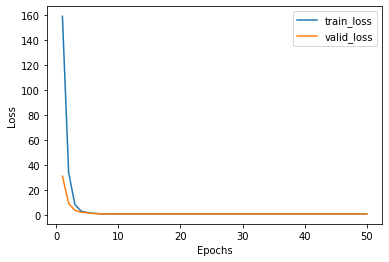

In [171]:
from matplotlib import pyplot as plt
epochs = range(1, len(loss_hist_train) + 1)
plt.plot(epochs, loss_hist_train, label='train_loss')
plt.plot(epochs, loss_hist_valid, label='valid_loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show 

In [172]:
def plot_data(simulated_zeta, predicted_zeta):
    indices = range(len(simulated_zeta))
    
    fig, ax = plt.subplots(figsize=(10, 5))
    
    ax.plot(indices, predicted_zeta, color='blue', alpha=0.4)
    ax.plot(indices, simulated_zeta, color='orange', alpha=0.4)
    
    ax.scatter(indices, predicted_zeta, color='blue', label='Predicted Zeta')
    ax.scatter(indices, simulated_zeta, color='orange', label='Simulated Zeta')
    
    ax.set_title('Predicted vs Simulated Elongation Rate')
    ax.set_xlabel('Index')
    ax.set_ylabel('Elongation Rate')
    ax.legend()

    plt.show()


In [173]:
tstdl = DataLoader(tstset, batch_size=batch_size, num_workers=0, shuffle=False, pin_memory=True)

In [174]:
model.eval()

data_iter = iter(tstdl)

number of samples: 4
predicted zeta:
tensor([0.4864, 0.4893, 0.4908, 0.4909, 0.4914, 0.4906, 0.4906, 0.5000, 0.4906,
        0.4899, 0.4920, 0.4907, 0.4884, 0.4851, 0.4898, 0.4879, 0.4913, 0.4899,
        0.4885, 0.4872, 0.4885, 0.4900, 0.4846, 0.4891, 0.4885, 0.4904, 0.4892,
        0.4879, 0.4871, 0.4871, 0.4902, 0.4887, 0.4891, 0.4884, 0.4899, 0.4895,
        0.4927, 0.4899, 0.4886, 0.4905, 0.4893, 0.4906, 0.4891, 0.4885, 0.4892,
        0.4888, 0.4904, 0.4879, 0.4905, 0.4928, 0.4878, 0.4878, 0.4891, 0.4884,
        0.4884, 0.4885, 0.4865, 0.4916, 0.4893, 0.4878, 0.4885, 0.4899, 0.4901,
        0.4893])
simulated zeta:
tensor([1.1720, 1.0642, 0.8242, 0.8863, 0.7200, 0.8177, 0.9593, 1.7027, 0.8175,
        0.9321, 0.6295, 0.8222, 1.2054, 1.5221, 0.9293, 1.3834, 0.7173, 0.9316,
        1.2115, 1.0334, 1.1117, 0.8604, 1.7568, 1.0587, 0.7919, 1.1138, 1.4631,
        0.9073, 1.0279, 0.7690, 0.9423, 1.2187, 1.4589, 1.2058, 1.0932, 1.2619,
        0.5419, 0.9299, 1.2165, 0.8153, 0.9705, 0.

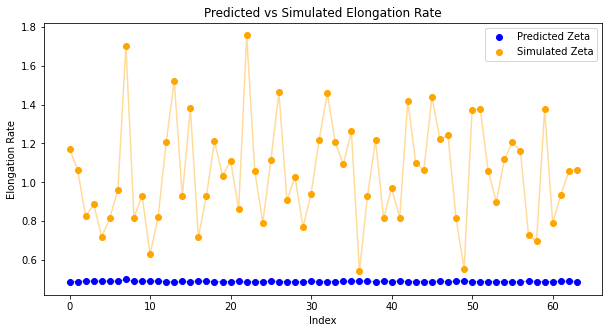

number of samples: 4
predicted zeta:
tensor([0.4892, 0.4871, 0.4895, 0.4899, 0.4878, 0.4878, 0.4913, 0.4936, 0.4899,
        0.4898, 0.4877, 0.4915, 0.4913, 0.4886, 0.4893, 0.4885, 0.4880, 0.4899,
        0.4899, 0.4899, 0.4878, 0.4900, 0.4887, 0.4870, 0.4906, 0.4915, 0.4892,
        0.4893, 0.4891, 0.4920, 0.4886, 0.4921, 0.4886, 0.4878, 0.4885, 0.4897,
        0.4878, 0.4920, 0.4910, 0.4930, 0.4872, 0.4871, 0.4899, 0.4885, 0.4918,
        0.4896, 0.4891, 0.4885, 0.4885, 0.4878, 0.4893, 0.4884, 0.4887, 0.4888,
        0.4858, 0.4891, 0.4878, 0.4928, 0.4892, 0.4884, 0.4891, 0.4887, 0.4913,
        0.4892])
simulated zeta:
tensor([1.0624, 1.0265, 1.0916, 0.9301, 1.3753, 0.9017, 0.7160, 1.3050, 0.9301,
        0.9286, 1.8403, 0.4736, 0.7160, 1.0845, 0.6991, 0.7916, 1.2745, 0.6107,
        0.8437, 0.9296, 1.3754, 0.9356, 1.2190, 1.5616, 0.8169, 0.7223, 0.6947,
        0.6972, 1.3440, 0.6289, 1.1019, 0.6318, 0.9897, 1.3749, 1.2066, 1.0860,
        0.9017, 0.6292, 1.1493, 1.4717, 1.0328, 1.

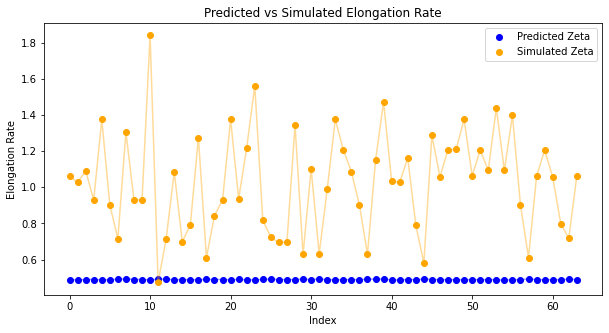

number of samples: 4
predicted zeta:
tensor([0.4914, 0.4888, 0.4903, 0.4885, 0.4923, 0.4884, 0.4899, 0.4893, 0.4893,
        0.4903, 0.4891, 0.4899, 0.4920, 0.4917, 0.4906, 0.5050, 0.4889, 0.4892,
        0.4871, 0.4884, 0.4885, 0.4907, 0.4886, 0.4899, 0.4912, 0.4877, 0.4881,
        0.4912, 0.4901, 0.4913, 0.4900, 0.4904, 0.4888, 0.4903, 0.4901, 0.4880,
        0.4906, 0.4863, 0.4900, 0.4897, 0.4906, 0.4872, 0.4913, 0.4877, 0.4870,
        0.4899, 0.4910, 0.4900, 0.4888, 0.4881, 0.4871, 0.4878, 0.4878, 0.4888,
        0.4850, 0.4871, 0.4906, 0.4891, 0.4891, 0.4898, 0.4901, 0.4868, 0.4877,
        0.4886])
simulated zeta:
tensor([0.9957, 1.0269, 1.2328, 1.2109, 1.4823, 1.2063, 0.9313, 1.0671, 0.9700,
        0.7735, 1.0571, 0.9317, 0.6290, 0.7312, 0.8191, 1.9253, 1.4467, 1.0632,
        1.0287, 1.2043, 1.2069, 0.8199, 0.7685, 0.6103, 0.9843, 1.2941, 0.9125,
        0.8389, 0.9752, 0.7168, 0.9923, 1.1205, 1.0936, 0.8374, 0.9398, 1.3409,
        0.8192, 1.7804, 0.9368, 1.2601, 0.8177, 1.

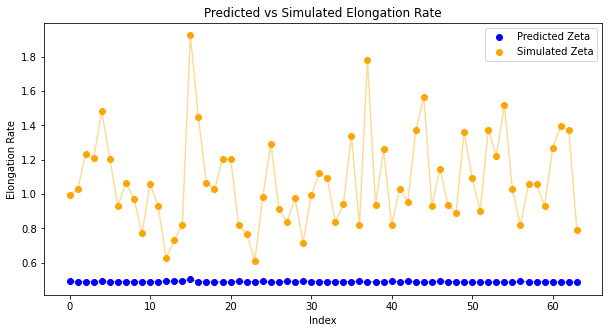

number of samples: 4
predicted zeta:
tensor([0.4885, 0.4883, 0.4881, 0.4902, 0.4892, 0.4891, 0.4884, 0.4898, 0.4923,
        0.4877, 0.4892, 0.4949, 0.4879, 0.4927, 0.4905, 0.4880, 0.4875, 0.4878,
        0.4885, 0.4892, 0.4913, 0.4899, 0.4893, 0.4885, 0.4899, 0.4885, 0.4884,
        0.4932, 0.4888, 0.4906, 0.4913, 0.4898, 0.4913, 0.4878, 0.4937, 0.4878,
        0.4899, 0.4914, 0.4871, 0.4906, 0.4872, 0.4863, 0.4894, 0.4871, 0.4886,
        0.4911, 0.4879, 0.4886, 0.4892, 0.4929, 0.4894, 0.4879, 0.4870, 0.4906,
        0.4888, 0.4899, 0.4892, 0.4899, 0.4892, 0.4927, 0.4878, 0.4862, 0.4903,
        0.4896])
simulated zeta:
tensor([1.2069, 1.4425, 1.3977, 0.9432, 1.0617, 0.9491, 1.2056, 0.9283, 0.6389,
        1.3729, 1.0606, 0.8595, 0.9056, 0.5517, 0.8154, 1.3877, 1.6661, 0.9025,
        1.0934, 1.0610, 0.7174, 0.6100, 1.0672, 1.2088, 0.9329, 1.2084, 1.2044,
        0.5636, 0.8415, 0.8171, 0.7159, 0.9288, 0.7173, 0.9021, 1.8358, 0.9028,
        0.9320, 0.8896, 1.5668, 0.8184, 1.5743, 1.

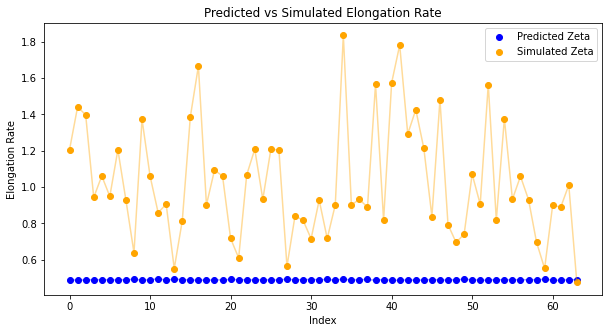

In [175]:
for i in range(0, 4):
    inputs = next(data_iter) 
    print("number of samples: " + str(len(inputs)))

    with torch.no_grad():
        y_inputs = inputs['Y_ji'].to(device)
        rho_ji = model(y_inputs)

    simulated_zeta = inputs['Z_ji']
    # convert log(Z) outputs to Z
    predicted_zeta = torch.exp(rho_ji.cpu().squeeze())
    print("predicted zeta:")
    print(predicted_zeta)

    print("simulated zeta:")
    print(simulated_zeta)

    plot_data(simulated_zeta, predicted_zeta)

In [114]:
import torch.nn.functional as F

predicted_zeta = []
simulated_zeta = []
with torch.no_grad():
    for batch in tstdl:
        y_inputs = batch['Y_ji'].to(device)
        rho_ji = model(y_inputs)
        # convert log(Z) outputs to Z
        predicted_zeta.append(torch.exp(rho_ji.cpu()))
        simulated_zeta.append(batch['Z_ji'])

predicted_zeta = torch.cat(predicted_zeta, dim=0)
simulated_zeta = torch.cat(simulated_zeta, dim=0)
mae = F.l1_loss(predicted_zeta.squeeze(), simulated_zeta)
mse = F.mse_loss(predicted_zeta.squeeze(), simulated_zeta)

print(f"Mean Absolute Error: {mae.item():.4f}")
print(f"Mean Squared Error: {mse.item():.4f}")

Mean Absolute Error: 1.4545
Mean Squared Error: 2.1965
